# Generate Cubic Lattices of Various Shape, Sizes and Topologies

The Cubic lattice network is the most commonly used pore network topology by far. When people first learn about pore network modeling they often insist on creating networks that are topologically equivalent or representative of the real network (i.e. random networks extracted from tomography images). In reality, however, a simple cubic network provides a very passable representation of more complex topologies, and provides several additional benefits as well; namely they are much easier to visualize, and applying boundary conditions is easier since the faces of the network are flat.

The examples below will demonstrate how to create various cubic lattice networks in OpenPNM using the Cubic class, as well as illustrating a few topological manipulations that can be performed, such as adding boundary pores, and trimming throats to create a more random-like topology.

## Basic Cubic Lattice with Different Connectivity

Let's start with the most basic cubic lattice:

In [1]:
import os
import warnings
import numpy as np
import openpnm as op
np.random.seed(10)
ws = op.Workspace()
ws.settings['loglevel'] = 40
warnings.filterwarnings('ignore')
pn = op.network.Cubic(shape=[10, 10, 10], spacing=1, connectivity=6)

In this case ```pn``` will be a 10 x 10 x 10 *cube* with each pore spaced 1 *unit* away from it's neighbors in all directions.  Each pore is connected to the 6 neighbors adjacent to each *face* of the cubic lattice site in which it sits.  The image below illustrates the resulting network with pores shown as white spheres, along with a zoomed in view of the internals, showing the connectivity of the pores.

<img src="http://i.imgur.com/JTUodGy.png" style="width: 60%" align="left"/>

The **Cubic** network generator applies 6-connectivity by default, but different values can be specified.  In a cubic lattice, each pore can have up to 26 neighbors: 6 on each face, 8 on each corner, and 12 on each edge.  This is illustrated in the image below.

<img src="http://i.imgur.com/ACiQFtJ.png" style="width: 60%" align="left"/>

Cubic networks can have any combination of corners, edges, and faces, which is controlled with the ```connectivity``` argument by specifying the total number of neighbors (6, 14, 18, 20, or 26).  Note that 8 and 12 are not permitted since these lead to disconnected networks.

In [2]:
pn = op.network.Cubic(shape=[10, 10, 10], spacing=1, connectivity=26)

This yields the following network, which clearly has a LOT of connections!

<img src="http://i.imgur.com/PS6d7CO.png" style="width: 70%" align="left"/>

## Trimming Random Throats to Adjust Coordination Number

Often it is desired to create a distribution of coordination numbers on each pore, such that some pores have 2 neighbors and other have 8, while the overall average may be around 5.  It is computationally very challenging to specify a specific distribution, but OpenPNM does allow you to create a network with a specific *average* connectivity.  This is done by creating a network with far more connections than needed (say 26), then trimming some fraction of throats from the network to reduce the coordination.  

In [3]:
import scipy as sp
pn = op.network.Cubic(shape=[10, 10, 10], spacing=[1, 1, 1], connectivity=26)
print(pn.num_throats())

10476


The most basic way to do this is to just trim arbitrary throats as shown below, but this can lead to problems of accidentally creating isolated and disconnected clusters.

In [4]:
throats_to_trim = np.random.randint(low=0, high=pn.Nt-1, size=500)
from openpnm import topotools as tt
tt.trim(network=pn, throats=throats_to_trim)
# randint returns some duplicate numbers so actual number of trimmed throats varies
assert pn.num_throats() < 10476

The following image shows histogram of the pore connectivity before and after trimming.  Before trimming the coordination numbers fall into 4 distinct bins depending on where the pores lies (internal, face, edge or corner), while after trimming the coordination numbers show some distribution around their original values.  If the trimming is too aggressive, OpenPNM might report an error message saying that isolated pores exist, which means that some regions of the network are now disconnected from the main network due to a lack of connected throats.

<img src="http://i.imgur.com/Z4HgMYC.png" style="width: 70%" align="left"/>

In order to allow more aggressive trimming without creating topological problems, OpenPNM offers a tool in the ``topotools`` module called ``reduce_coordination``, which accepts an average coordination number.  This function works by first computing the minimum-spanning tree of the network (which is a set of connections that ensures every pore is connected), then deletes throats that are NOT part of the spanning tree to ensure that connection is maintained.  

In [5]:
pn = op.network.Cubic(shape=[10, 10, 10], spacing=[1, 1, 1], connectivity=26)
op.topotools.reduce_coordination(network=pn, z=5)

Now plotting the histogram we can see that indeed the average coordination was obtained.  Note, however, that the distribution is skewed and has a long tail.  The ``reduce_coordination`` function does not (yet) control the shapre of the distribution.

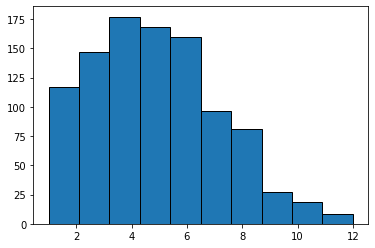

In [6]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(pn.num_neighbors(pn.Ps), edgecolor='k')
fig.patch.set_facecolor('white')


## Creating Domains with More Interesting Shapes

### Rectangular Domains with Non-Uniform Spacing

The ```shape``` and ```spacing``` arguments can of course be adjusted to create domains other than simple cubes:

In [7]:
pn = op.network.Cubic(shape=[10, 20, 20], spacing=[0.001, 0.03, 0.02])

This results in the following network with is squished in the x-direction.  Note that this can also be accomplished after the fact by simple scaling the coords (e.g. ``pn['pore.coords'] =* [0.001, 0.03, 0.02]``).

<img src="http://i.imgur.com/ICEAO7p.png" style="width: 70%" align="left"/>

### Spherical and Other Arbitrary Domains

It's also possible to obtain cubic networks of arbitrary shapes (i.e. spheres), but still with *cubic* connectivity.  This is accomplished using the ``CubicTemplate`` class, which accepts a binary image of 1's and 0's.  The network will have pores where the 1's are and 0's elsewhere.  For instance, to make a spherical domain  for a catalyst pellet, generate an image of a sphere using Scipy's NDimage module, the pass this image to **Cubic** as follows:

In [8]:
import scipy.ndimage as spim
im = np.ones([21, 21, 21])
im[10, 10, 10] = 0
dt = spim.distance_transform_bf(input=im)
sphere = dt < 10
pn = op.network.CubicTemplate(template=sphere, spacing=0.1)

This results in the following:

<img src="http://i.imgur.com/eyFHqNx.png" style="width: 60%" align="left"/>

All images of networks were made with paraview by exporting a VTK file with the following command:

In [9]:
op.io.VTK.save(network=pn, filename='network')
print(f"Does 'network.vtk' exist? {os.path.isfile('network.vtp')}")

Does 'network.vtk' exist? True
